# Python Training for Analytics: Exercise 6

prepared by: Stefanie Molin

## Background
The purpose of this exercise is to handle a medium-hard use case taken from actual AX work. To do so, I will adapt some exercises from the Problem Sets of my R training: [R Training Using Company Data](https://github.com/stefmolin/R-training-program). We will cover:

- Pulling data from Vertica
- Manipulating the resulting dataframe
- Providing some plots to illustrate the results
- Working in a notebook and some markdown
- String formatting
- Dealing with datetimes

## The request
The AS wants an analysis of conversions for a specific client. The client is looking into using a 10 hour PC window and has asked about certain products being in the banners, but not being purchased with the same frequency despite being clicked on. In particular, the AS is looking for:

1. the percent of conversions since days since last visit
2. an analysis of clicked vs. purchased items by click type and device
3. post-click conversions on a different lookback by day


## Requirements
Before we can do any analysis, we need to make sure our computers have the appropriate packages installed. For this notebook you will need:

- `sqlalchemy`
- `sqlalchemy-vertica`
- `pandas`
- `matplotlib`

### sqlalchemy-vertica Installation Troubleshooting
If you are unable to install `sqlalchemy-vertica` with `pip` or `conda`, try this:
```
git clone https://github.com/LocusEnergy/vertica-sqlalchemy
cd vertica-sqlalchemy
python setup.py install
```

## Caveats
This training will be dealing with specific tickets that have come in for the advertiser AX. We understand that we have AX from various teams completing these trainings, so some of the requests here may seem alien. As such, we trust that you can all write SQL, so feel free to attempt to write the appropriate query, however, you can find the queries in the "hints" folder should you need them. For the most part, the first TODO in each mini-exercise will be the query and the remaining 2 will involve manipulating and presenting the data in Python. The idea is to show you some cool tips and tricks that can help you automate your workflow and make reproducible analyses as well as write functions to package up processes allowing you to easily share your work.

## Notebook Setup
First, we import the modules we will use for this exercise and define a utility function to query Vertica.

In [34]:
from sqlalchemy import create_engine
# must have sqlalchemy-vertica installed
import pandas as pd
import getpass
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import PercentFormatter

# set graph sizes
rcParams['figure.figsize'] = [10, 4.8]

def query_vertica(query):
    '''
    This function will query Vertica using SQLAlchemy and return a list of tuples.
    You can use the results as is or turn them into a pandas dataframe by using:
        df = pd.DataFrame(results, columns=['col_1_name', 'col_2_name', 'etc.'])

        Params:
            query = String with the query you want to run (you will be prompted for your password)
    '''
    username = getpass.getuser()
    password = getpass.getpass('Vertica password [HIDDEN]: ')
    db_uri = 'vertica+vertica_python://{username}:{password}@<vertica_cluster>:<port>/<DB>?ConnectionLoadBalance=true'\
             .format(username=username, password=password)
    engine = create_engine(db_uri, echo=False)
    results = engine.execute(query).fetchall()
    engine.dispose
    return results


Make sure you are able to query Vertica by running a simple query.

In [2]:
# make sure it works
results = query_vertica("SELECT * FROM schema_1.table_1")
df = pd.DataFrame(results, columns=['event_id', 'event_name'])
print(df.head(6))

   event_id    event_name
0         1          Page
1         2      Category
2         3       Listing
3         4  ItemPageView
4         5        Basket
5         6         Sales


## The Analysis
We were asked to look into:
- the percent of conversions since days since last visit
- an analysis of clicked vs. purchased items by click type and device
- post-click conversions on a different lookback by day

### Percent of Conversions by Days Since Last Visit
TODOs:

1. Write a query to pull transactions by days since last visit for Macy's campaign 66182.
2. Clean up the data to only have entries where the percentage of total transactions is greater than 1%.
3. Create a bar plot of the results using the method of your choice.

In [3]:
# TODO 1
# query for transactions by days since last visit
transactions_query = '''
        SELECT
            ROUND(days_last_visit, 0) AS days_last_visit
            , SUM(transactions) AS transactions
        FROM
            (SELECT
                arbitrage_id
                , COUNT(distinct transaction_id) AS transactions
            FROM
                schema_1.transactions_lookups
            WHERE
                merchant_id = {partner_id}
                AND attribution_type = 'pc'
                AND day >= CURRENT_DATE() - 30
                AND campaign_id = {campaign_id}
            GROUP BY
                arbitrage_id) mt
        JOIN
            (SELECT
                arbitrage_id
                , days_last_visit
            FROM
                schema_1.clicks_stats
            WHERE
                merchant_id = {partner_id}
                AND day >= CURRENT_DATE() - 60
            GROUP BY
                arbitrage_id
                , days_last_visit) clk
        ON
            clk.arbitrage_id = mt.arbitrage_id
        GROUP BY
            ROUND(days_last_visit, 0)
        '''.format(partner_id=1111, campaign_id=9876543)

# query for results
transactions_results = query_vertica(transactions_query)
transactions_dlv = pd.DataFrame(transactions_results,
                                columns=['days_last_visit', 'transactions'])

# check data
print(transactions_dlv.head())
print('Total transactions: ' + str(transactions_dlv.transactions.sum()))

   days_last_visit  transactions
0             92.0             1
1            101.0             2
2            100.0             2
3            114.0             1
4             16.0           579
Total transactions: 150270


In [4]:
# TODO 2
# clean up the data, add percent column, arrange, only >= 1%
transactions_dlv = transactions_dlv[transactions_dlv.days_last_visit.between(0, 400, inclusive=True)]\
                   .assign(percent_of_total = transactions_dlv.transactions / transactions_dlv.transactions.sum())
transactions_dlv = transactions_dlv[transactions_dlv.percent_of_total >= 0.01].sort_values(by=['days_last_visit'])


# make sure the days since last visit is an integer
transactions_dlv.days_last_visit = transactions_dlv.days_last_visit.astype(int)

print(transactions_dlv.head())

     days_last_visit  transactions  percent_of_total
12                 0         49641          0.330345
121                1         32077          0.213462
99                 2         15452          0.102828
115                3         10033          0.066766
40                 4          7377          0.049092


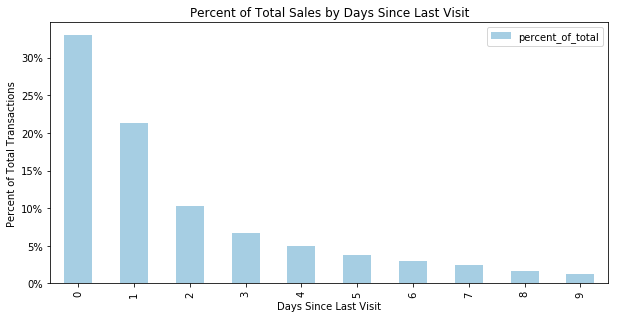

In [35]:
# TODO 3
axes = transactions_dlv.plot(x='days_last_visit', y='percent_of_total', 
                             kind='bar', label='percent_of_total', 
                             colormap='Paired', use_index=True)
axes.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0)) # this is one bc they have already been divided
plt.title('Percent of Total Sales by Days Since Last Visit')
plt.xlabel('Days Since Last Visit')
plt.ylabel('Percent of Total Transactions')
plt.show()

### Clicked vs. Purchased Items by Click Type and Device
TODOS:

1. Write a query to pull total transactions and total same product (clicked and purchased) by click type (product or logo) and device type.
2. Use `pandas` to filter out the logo clicks and calculate the percent of purchased products that were the same as the clicked product.
3. Use `matplotlib` or `pandas` to generate a labelled barplot to show your findings.

In [6]:
# TODO 1
c_vs_p_query = '''
        SELECT
            CASE
                WHEN clicked_item_id IS NULL THEN 'Logo'
                ELSE 'Product'
            END AS click_type
            , evt2.device_type AS device_type
            , COUNT(DISTINCT mt.transaction_id) AS total_transactions
            , COUNT(DISTINCT CASE WHEN clicked_item_id = product_internal_id
                                  THEN mt.transaction_id ELSE NULL END) AS same_product
        FROM
            (SELECT
                clicked_item_id
                , transaction_id
            FROM
                schema_1.transaction_lookups_granular
            WHERE
                merchant_id = {partner_id}
                AND attribution_type = 'pc'
                AND day >= CURRENT_DATE() - 30
            GROUP BY
                clicked_item_id
                , transaction_id) mt
        JOIN
            (SELECT
                transaction_id
                , product_internal_id
            FROM
                schema_1.transaction_lookups
            WHERE
                day >= CURRENT_DATE() - 30
                AND merchant_id = {partner_id}
            GROUP BY
                transaction_id
                , product_internal_id) evt
        ON
            evt.transaction_id = mt.transaction_id
        JOIN
            (SELECT
                transaction_id
                , device_type
            FROM
                schema_1.events_lookup
            WHERE
                day >= CURRENT_DATE() - 30
                AND merchant_id = {partner_id}
                AND event_name_id = 6
            GROUP BY
                transaction_id
                , device_type) evt2
        ON
            evt2.transaction_id = evt.transaction_id
        GROUP BY
            CASE
                WHEN clicked_item_id IS NULL THEN 'Logo'
                ELSE 'Product'
            END
            , evt2.device_type
        '''.format(partner_id=1111)

# query for results
clicked_vs_purchased_results = query_vertica(c_vs_p_query)
clicked_vs_purchased = pd.DataFrame(clicked_vs_purchased_results,
                                    columns=['click_type', 'device_type', 'total_transactions', 'same_product'])
print(clicked_vs_purchased.head())

  click_type       device_type  total_transactions  same_product
0       Logo  Desktop - Safari                 691             0
1    Product              iPad                5451           695
2       Logo           Android                2308             0
3    Product           Android               23696          3131
4       Logo           Unknown                 232             0


In [7]:
# TODO 2
# filter out the logo clicks and add the column for the graph
clicked_vs_purchased = clicked_vs_purchased[clicked_vs_purchased.click_type != 'Logo']\
                       .assign(percent_same = lambda df: df.same_product / df.total_transactions)
print(clicked_vs_purchased.head())

   click_type       device_type  total_transactions  same_product  \
1     Product              iPad                5451           695   
3     Product           Android               23696          3131   
6     Product  Desktop - Safari                7527          1043   
8     Product            iPhone                6177           738   
10    Product           Unknown                2630           344   

    percent_same  
1       0.127500  
3       0.132132  
6       0.138568  
8       0.119475  
10      0.130798  


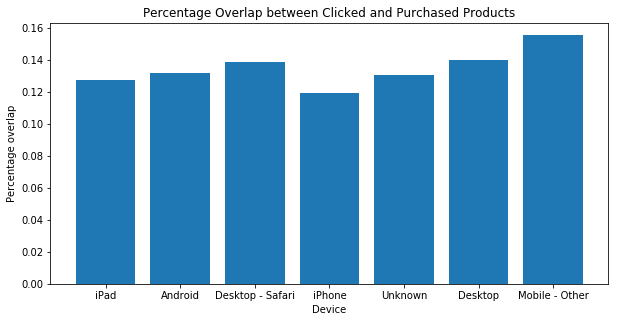

In [36]:
# TODO 3 using matplotlib
# make barplot with matplotlib
plt.bar(x=clicked_vs_purchased['device_type'], height=clicked_vs_purchased['percent_same'])
plt.title('Percentage Overlap between Clicked and Purchased Products')
plt.xlabel('Device')
plt.ylabel('Percentage overlap')
plt.show()

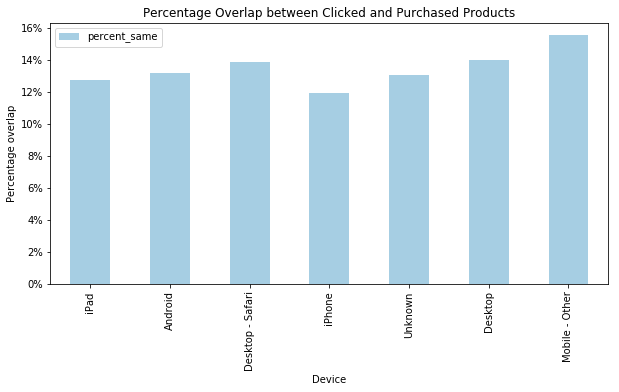

In [37]:
# TODO 3 using pandas
axes = clicked_vs_purchased.plot(x='device_type', y='percent_same', 
                                 kind='bar', label='percent_same', 
                                 colormap='Paired', use_index=True)
axes.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0)) # this is one bc they have already been divided
plt.title('Percentage Overlap between Clicked and Purchased Products')
plt.xlabel('Device')
plt.ylabel('Percentage overlap')
plt.show()

### Post-click Conversions with a Custom Attribution Window
TODOs:

1. Write a function to calculate custom attribution by day for a given partner, attribution, start/end date, attribution window in seconds, and deduplication flag.
2. Call the function on the client for the last 30 days at 10HR PC with deduplication off.
3. Print out the first 7 rows.

In [20]:
# TODO 1
# define the function for querying custom attribution
def custom_attribution(partner_id, start_date, end_date, attribution_type, window_seconds, dedup=False):
    """
    Pull custom attribution by day and return a dataframe
    
    Requires: 
        pandas installed as pd
        query_vertica function
    
    Params: 
        partner_id - partner_id of the client
        start_date - start_date as a string (inclusive)
        end_date - end date as a string (inclusive)
        attribution_type - 'pc' or 'pv'
        window_seconds - length of the attribution window in seconds
        dedup - Boolean indicating whether or not deduplication flag should be used"""
    if dedup:
        dedup_clause = "AND deduplication_matching = 1"
    else:
        dedup_clause = ""
    # base query
    query = '''
        SELECT
            day
            , attribution_type
            , COUNT(DISTINCT transaction_id) AS numtrans
        FROM
            schema_1.transactions_lookup_granular
        WHERE
            merchant_id = {partner_id}
            AND attribution_type = '{attribution_type}'
            AND day BETWEEN '{end}' AND '{start}'
            AND (trans_timestamp - click_timestamp) <= {window}
            {dedup_clause}
        GROUP BY
            day
            , attribution_type
        ORDER BY
            day
            , attribution_type
        '''.format(partner_id=partner_id, attribution_type=attribution_type,
                  start=start_date, end=end_date, window=window_seconds, dedup_clause=dedup_clause)
    
    results = query_vertica(query)
    return pd.DataFrame(results, columns=['day', 'attribution_type', 'numtrans'])

In [21]:
# TODO 2
# get dates
from datetime import datetime, timedelta

start_date = datetime.today().strftime('%Y-%m-%d')
end_date = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')

client_custom_attribution = custom_attribution(5535, start_date, end_date, attribution_type='pc', window_seconds=10*60*60)

In [22]:
# TODO 3
print(client_custom_attribution.head(7))

          day attribution_type  numtrans
0  2018-02-14               pc      1530
1  2018-02-15               pc      1770
2  2018-02-16               pc      2143
3  2018-02-17               pc      1418
4  2018-02-18               pc       988
5  2018-02-19               pc      1406
6  2018-02-20               pc      1155


## Congratulations!
You did it! Three requests all in one notebook. You can now export this to an HTML or PDF and easily attach to the person who sent you the Jira request. It is easy for them to share with others as well. Don't be afraid to take advantage of adding markdown cells to explain sections and discuss your findings. Keep in mind there are multiple ways to approach a problem like this, so feel free to execute it in a different way. 